In [1]:
import numpy as np
import pandas as pd
from os import path
from random import choice, shuffle

from ga4stpg.graph import Graph, ReaderORLibrary
from ga4stpg.graph.steiner import (prunning_mst, shortest_path,
                            shortest_path_origin_prim,
                            prunning_kruskal_mst,
                            shortest_path_with_origin)

from ga4stpg.graph.util import (is_steiner_tree, 
                                has_cycle,
                                gg_total_weight)
from ga4stpg.graph.algorithms import kruskal, prim

In [2]:
# input
dataset_file = 'steinc5.txt'
file = path.join('..', '..', 'ppgi-stpg-gpx', 'datasets','ORLibrary', dataset_file)

assert path.exists(file)

reader = ReaderORLibrary()
stpg = reader.parser(file)

In [3]:
from ga4stpg.tree.kruskalpartitioning import KruskalBasedPartitioning
from ga4stpg.tree.evaluation import EvaluateTreeGraph

crossover = KruskalBasedPartitioning(stpg)
evaluator = EvaluateTreeGraph(stpg)

In [4]:
%%time
vertices = list(stpg.graph.vertices)

shuffle(vertices)

data = list()
assert len(vertices) >= 200, "meh"

for _ in range(200):
    v = vertices.pop()
    aa, aa_cost = prunning_mst(stpg.graph, v, stpg.terminals)
    is_aa_st, _ = is_steiner_tree(aa, stpg)
    
    u = vertices.pop()
    bb, bb_cost = prunning_mst(stpg.graph, u, stpg.terminals)
    is_bb_st, _ = is_steiner_tree(bb, stpg)
    
    child = crossover(aa, bb)
    cc_cost, _ = evaluator(child)
    is_cc_st, _ = is_steiner_tree(child, stpg)
    
    data.append([v, u, is_aa_st, is_bb_st, is_cc_st, aa_cost, bb_cost, cc_cost])

Wall time: 4.63 s


In [5]:
col = [
    'start_a', 
    'start_b', 
    'is_aa_st', 
    'is_bb_st', 
    'is_cc_st' ,
    'a_cost', 
    'b_cost', 
    'c_cost'
    ]
frame = pd.DataFrame(data, columns=col)

<AxesSubplot:>

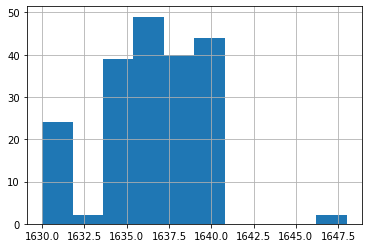

In [6]:
frame['a_cost'].hist()

<AxesSubplot:>

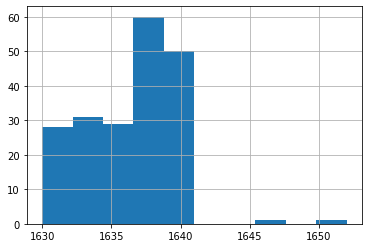

In [7]:
frame['b_cost'].hist()

<AxesSubplot:>

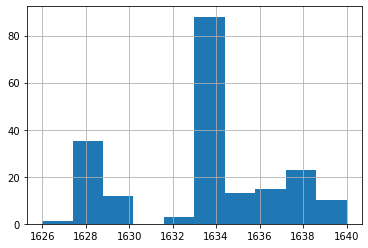

In [8]:
frame['c_cost'].hist()

In [9]:
frame[['is_aa_st',	'is_bb_st',	'is_cc_st']].describe()

,is_aa_st,is_bb_st,is_cc_st
count,200,200,200
unique,1,1,1
top,True,True,True
freq,200,200,200


In [10]:
frame['less_both'] = (frame['c_cost'] < frame['a_cost']) & (frame['c_cost'] < frame['b_cost'])

In [18]:
frame['equal_at_least'] = (frame['c_cost'] == frame['a_cost']) | (frame['c_cost'] == frame['b_cost'])

In [11]:
frame['less_equal_both'] = (frame['c_cost'] <= frame['a_cost']) & (frame['c_cost'] <= frame['b_cost'])

In [12]:
frame['less_equal_a'] = (frame['c_cost'] <= frame['a_cost'])

In [13]:
frame['less_equal_b'] = (frame['c_cost'] <= frame['b_cost'])

In [14]:
np.all(frame['less_equal_both'])

True

In [15]:
frame[['less_both', 'less_equal_a', 'less_equal_b', 'less_equal_both']].describe()

,less_both,less_equal_a,less_equal_b,less_equal_both
count,200,200,200,200
unique,2,1,1,1
top,False,True,True,True
freq,113,200,200,200


In [16]:
frame['diff_from_a'] = frame['a_cost'] - frame['c_cost']
frame['diff_from_b'] = frame['b_cost'] - frame['c_cost']

In [17]:
df_stats = frame[['a_cost',	'b_cost', 'c_cost', 'diff_from_a', 'diff_from_b']].describe()

df_stats

,a_cost,b_cost,c_cost,diff_from_a,diff_from_b
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,1636.370000,1636.465000,1633.600000,2.770000,2.865000
std,3.299627,3.488499,3.408532,3.030349,3.356053
min,1630.000000,1630.000000,1626.000000,0.000000,0.000000
25%,1634.000000,1634.000000,1632.000000,0.000000,0.000000
50%,1637.000000,1637.000000,1634.000000,2.000000,2.000000
75%,1638.000000,1640.000000,1635.000000,5.000000,4.000000
max,1648.000000,1652.000000,1640.000000,14.000000,17.000000


In [19]:
frame[['diff_from_a', 'diff_from_b']].describe()

,diff_from_a,diff_from_b
count,200.000000,200.000000
mean,2.770000,2.865000
std,3.030349,3.356053
min,0.000000,0.000000
25%,0.000000,0.000000
50%,2.000000,2.000000
75%,5.000000,4.000000
max,14.000000,17.000000
